Diffusion モデルのテスト

https://github.com/azad-academy/denoising-diffusion-model/blob/main/diffusion_model_demo.ipynb

に基づく


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_checkerboard,make_circles,make_moons,make_s_curve,make_swiss_roll
#from helper_plot import hdr_plot_style
import torch
#from utils import * 

In [ ]:
swiss_roll, _ = make_swiss_roll(10**4,noise=0.1)
swiss_roll = swiss_roll[:, [0, 2]]/10.0


s_curve, _= make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]]/10.0

moons, _ = make_moons(10**4, noise=0.1)

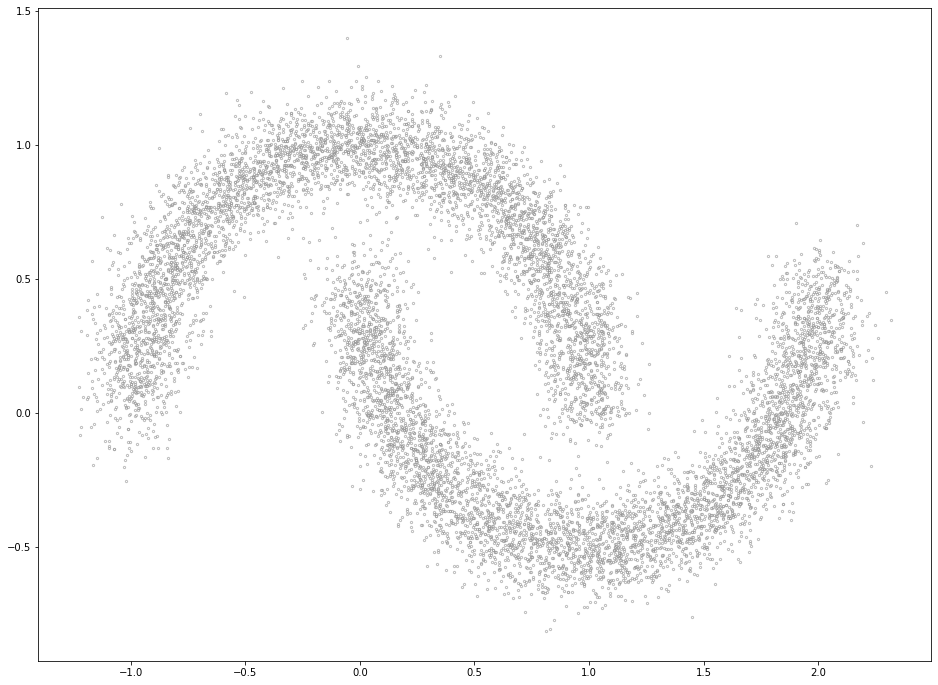

In [ ]:
plt.figure(figsize=(16,12))
#data = swiss_roll.T
#data = s_curve.T
data = moons.T
plt.scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5);

学習データをテンソルに変換

In [ ]:
dataset = torch.Tensor(data.T).float()

## 拡散プロセス

まず分散スケジュール$\beta_t$を作成する

In [ ]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

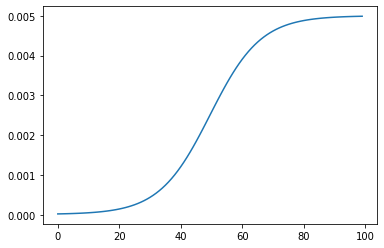

In [ ]:
num_steps = 100
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)
plt.plot(betas)

各種定数の定義

In [ ]:
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [ ]:
alphas

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999,
        0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9998, 0.9998, 0.9997, 0.9997,
        0.9997, 0.9996, 0.9996, 0.9996, 0.9995, 0.9995, 0.9994, 0.9993, 0.9993,
        0.9992, 0.9991, 0.9990, 0.9989, 0.9988, 0.9987, 0.9986, 0.9984, 0.9983,
        0.9982, 0.9980, 0.9979, 0.9977, 0.9976, 0.9974, 0.9973, 0.9971, 0.9970,
        0.9968, 0.9967, 0.9966, 0.9964, 0.9963, 0.9962, 0.9961, 0.9960, 0.9959,
        0.9958, 0.9957, 0.9957, 0.9956, 0.9955, 0.9955, 0.9954, 0.9954, 0.9953,
        0.9953, 0.9953, 0.9952, 0.9952, 0.9952, 0.9952, 0.9952, 0.9951, 0.9951,
        0.9951, 0.9951, 0.9951, 0.9951, 0.9951, 0.9951, 0.9951, 0.9950, 0.9950,
        0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950, 0.9950,
        0.9950])

In [ ]:
alphas_prod

tensor([1.0000, 1.0000, 0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9998, 0.9997,
        0.9997, 0.9996, 0.9996, 0.9995, 0.9994, 0.9994, 0.9993, 0.9992, 0.9991,
        0.9990, 0.9988, 0.9987, 0.9985, 0.9983, 0.9981, 0.9979, 0.9977, 0.9974,
        0.9971, 0.9967, 0.9963, 0.9959, 0.9954, 0.9948, 0.9942, 0.9936, 0.9928,
        0.9920, 0.9911, 0.9901, 0.9890, 0.9878, 0.9865, 0.9851, 0.9836, 0.9819,
        0.9801, 0.9781, 0.9761, 0.9738, 0.9715, 0.9690, 0.9663, 0.9635, 0.9606,
        0.9576, 0.9544, 0.9511, 0.9477, 0.9442, 0.9406, 0.9370, 0.9332, 0.9294,
        0.9255, 0.9215, 0.9175, 0.9135, 0.9094, 0.9053, 0.9012, 0.8970, 0.8928,
        0.8886, 0.8844, 0.8802, 0.8760, 0.8718, 0.8676, 0.8634, 0.8592, 0.8550,
        0.8508, 0.8467, 0.8425, 0.8383, 0.8342, 0.8301, 0.8260, 0.8219, 0.8178,
        0.8138, 0.8097, 0.8057, 0.8017, 0.7977, 0.7937, 0.7898, 0.7858, 0.7819,
        0.7780])

## 前向きサンプリング関数

In [ ]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

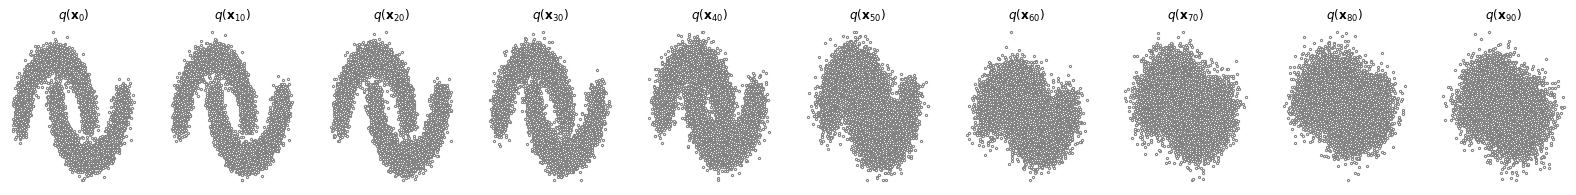

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    q_i = q_x(dataset, torch.tensor([i * 10]))
    axs[i].scatter(q_i[:, 0], q_i[:, 1],color='white',edgecolor='gray', s=5);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

## 逆拡散プロセス

In [ ]:
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

逆拡散用ニューラルネットワーク

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
        
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)

In [ ]:
def noise_estimation_loss(model, x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()

def p_sample_loop(model, shape,n_steps,alphas,betas,one_minus_alphas_bar_sqrt):
  cur_x = torch.randn(shape)
  x_seq = [cur_x]
  for i in reversed(range(n_steps)):
      cur_x = p_sample(model, cur_x, i,alphas,betas,one_minus_alphas_bar_sqrt)
      x_seq.append(cur_x)
  return x_seq

def p_sample(model, x, t,alphas,betas,one_minus_alphas_bar_sqrt):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)



## 訓練プロセス

In [ ]:
import torch.optim as optim

model = ConditionalModel(num_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 128

In [ ]:
for t in range(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if (t % 100 == 0):
        print(loss)

tensor(0.7651, grad_fn=<MeanBackward0>)
tensor(0.7009, grad_fn=<MeanBackward0>)
tensor(0.3730, grad_fn=<MeanBackward0>)
tensor(0.9717, grad_fn=<MeanBackward0>)
tensor(0.7588, grad_fn=<MeanBackward0>)
tensor(0.7775, grad_fn=<MeanBackward0>)
tensor(0.9087, grad_fn=<MeanBackward0>)
tensor(0.5516, grad_fn=<MeanBackward0>)
tensor(0.6029, grad_fn=<MeanBackward0>)
tensor(0.9910, grad_fn=<MeanBackward0>)


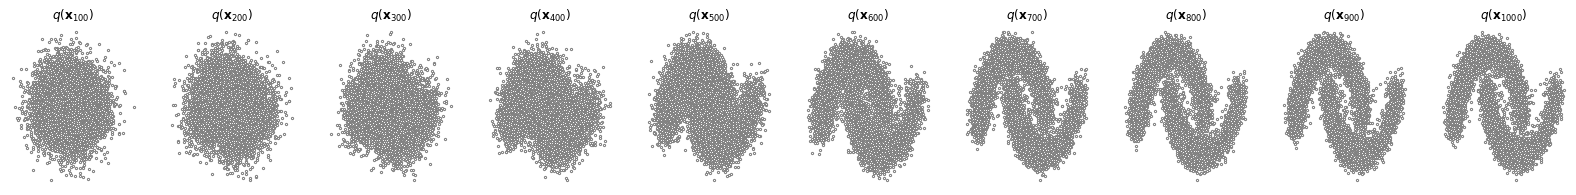

In [ ]:
x_seq = p_sample_loop(model, dataset.shape,num_steps,alphas,betas,one_minus_alphas_bar_sqrt)
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(1, 11):
  cur_x = x_seq[i * 10].detach()
  axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='gray', s=5);
  axs[i-1].set_axis_off(); 
  axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')